# Week 3: Using RNNs to predict time series

Welcome! In the previous assignment you used a vanilla deep neural network to create forecasts for generated time series. This time you will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating the same time series data as in last week's assignment.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the first week of the course.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html).



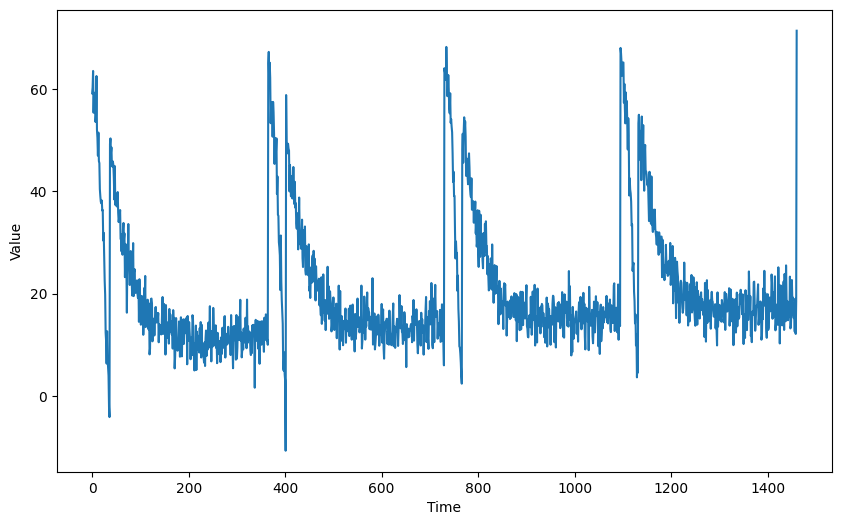

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:



In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture. Unlike previous weeks or courses in which you define your layers and compile the model in the same function, here you will first need to complete the `create_uncompiled_model` function below. 

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:
- Fill in the `Lambda` layers at the beginning and end of the network with the correct lamda functions.
- You should use `SimpleRNN` or `Bidirectional(LSTM)` as intermediate layers.
- The last layer of the network (before the last `Lambda`) should be a `Dense` layer.

In [23]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
        tf.keras.layers.SimpleRNN(40,return_sequences=True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100)
    ]) 
    
    ### END CODE HERE

    return model

In [24]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Your current architecture is compatible with the windowed dataset! :)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-23 23:11:34.401991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [25]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [26]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36.4855 - mae: 36.9804 - learning_rate: 1.0000e-06
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.8251 - mae: 11.3119 - learning_rate: 1.1220e-06
Epoch 3/100


2024-04-23 23:11:37.136001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:37.288744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.9271 - mae: 7.4097 - learning_rate: 1.2589e-06
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1595 - mae: 5.6333 - learning_rate: 1.4125e-06
Epoch 5/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.9850 - mae: 5.4556

2024-04-23 23:11:37.440474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:37.585385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1295 - mae: 4.6036 - learning_rate: 1.5849e-06
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0818 - mae: 4.5533 - learning_rate: 1.7783e-06
Epoch 7/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.6206 - mae: 3.0552

2024-04-23 23:11:37.725736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:37.855427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6645 - mae: 4.1253 - learning_rate: 1.9953e-06
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8110 - mae: 4.2778 - learning_rate: 2.2387e-06
Epoch 9/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 4.0312 - mae: 4.5124

2024-04-23 23:11:37.985949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:38.116651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8996 - mae: 4.3747 - learning_rate: 2.5119e-06
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4856 - mae: 3.9518 - learning_rate: 2.8184e-06
Epoch 11/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.3256 - mae: 2.8070

2024-04-23 23:11:38.254374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:38.381860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4634 - mae: 3.9360 - learning_rate: 3.1623e-06
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1770 - mae: 3.6397 - learning_rate: 3.5481e-06
Epoch 13/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 3.1438 - mae: 3.5835

2024-04-23 23:11:38.518894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:38.663704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4593 - mae: 3.9239 - learning_rate: 3.9811e-06
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5097 - mae: 3.9795 - learning_rate: 4.4668e-06
Epoch 15/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 3.3456 - mae: 3.8181

2024-04-23 23:11:38.799733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:38.932906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3694 - mae: 3.8373 - learning_rate: 5.0119e-06
Epoch 16/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9668 - mae: 4.4420 - learning_rate: 5.6234e-06
Epoch 17/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.4180 - mae: 3.8827

2024-04-23 23:11:39.074399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:39.203354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2844 - mae: 3.7547 - learning_rate: 6.3096e-06
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9486 - mae: 3.4085 - learning_rate: 7.0795e-06
Epoch 19/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.1138 - mae: 5.5677

2024-04-23 23:11:39.331015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:39.473010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3188 - mae: 3.7827 - learning_rate: 7.9433e-06
Epoch 20/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8596 - mae: 3.3239 - learning_rate: 8.9125e-06
Epoch 21/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 3.3468 - mae: 3.8192

2024-04-23 23:11:39.611062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:39.742394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2715 - mae: 3.7405 - learning_rate: 1.0000e-05
Epoch 22/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8487 - mae: 4.3205 - learning_rate: 1.1220e-05
Epoch 23/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.0705 - mae: 4.5399

2024-04-23 23:11:39.882215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:40.021175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0291 - mae: 3.4941 - learning_rate: 1.2589e-05
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6187 - mae: 4.0926 - learning_rate: 1.4125e-05
Epoch 25/100


2024-04-23 23:11:40.163115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:40.322970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7738 - mae: 3.2330 - learning_rate: 1.5849e-05
Epoch 26/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4537 - mae: 3.9296 - learning_rate: 1.7783e-05
Epoch 27/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 5.7523 - mae: 6.2505

2024-04-23 23:11:40.466792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:40.595808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1152 - mae: 4.5980 - learning_rate: 1.9953e-05
Epoch 28/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3680 - mae: 4.8441 - learning_rate: 2.2387e-05
Epoch 29/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 6.8529 - mae: 7.3417

2024-04-23 23:11:40.735068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:40.872431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0703 - mae: 7.5599 - learning_rate: 2.5119e-05
Epoch 30/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3197 - mae: 4.7998 - learning_rate: 2.8184e-05
Epoch 31/100


2024-04-23 23:11:41.004756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:41.152877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1311 - mae: 4.6047 - learning_rate: 3.1623e-05
Epoch 32/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5600 - mae: 4.0269 - learning_rate: 3.5481e-05
Epoch 33/100


2024-04-23 23:11:41.287395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:41.430918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4612 - mae: 5.9430 - learning_rate: 3.9811e-05
Epoch 34/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2606 - mae: 6.7442 - learning_rate: 4.4668e-05
Epoch 35/100


2024-04-23 23:11:41.571981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:41.716697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1870 - mae: 6.6700 - learning_rate: 5.0119e-05
Epoch 36/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7583 - mae: 7.2457 - learning_rate: 5.6234e-05
Epoch 37/100


2024-04-23 23:11:41.859316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:42.044011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8878 - mae: 6.3700 - learning_rate: 6.3096e-05
Epoch 38/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7160 - mae: 7.1992 - learning_rate: 7.0795e-05
Epoch 39/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 10.3913 - mae: 10.8856

2024-04-23 23:11:42.184999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:42.310939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5093 - mae: 12.0005 - learning_rate: 7.9433e-05
Epoch 40/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7356 - mae: 7.2237 - learning_rate: 8.9125e-05
Epoch 41/100


2024-04-23 23:11:42.439429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:42.583954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.0147 - mae: 10.5078 - learning_rate: 1.0000e-04
Epoch 42/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9353 - mae: 6.4159 - learning_rate: 1.1220e-04
Epoch 43/100


2024-04-23 23:11:42.744992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:42.891751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.3191 - mae: 17.8132 - learning_rate: 1.2589e-04
Epoch 44/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2014 - mae: 11.6961 - learning_rate: 1.4125e-04
Epoch 45/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 15.3199 - mae: 15.8199

2024-04-23 23:11:43.033977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:43.166700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2103 - mae: 7.6987 - learning_rate: 1.5849e-04
Epoch 46/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6442 - mae: 6.1251 - learning_rate: 1.7783e-04
Epoch 47/100


2024-04-23 23:11:43.298357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:43.446633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4904 - mae: 8.9782 - learning_rate: 1.9953e-04
Epoch 48/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.3060 - mae: 24.8044 - learning_rate: 2.2387e-04
Epoch 49/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.5213 - mae: 5.0172

2024-04-23 23:11:43.585004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:43.718243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.2165 - mae: 10.7042 - learning_rate: 2.5119e-04
Epoch 50/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9323 - mae: 7.4188 - learning_rate: 2.8184e-04
Epoch 51/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 6.0352 - mae: 6.4892

2024-04-23 23:11:43.842991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:43.984317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9698 - mae: 7.4547 - learning_rate: 3.1623e-04
Epoch 52/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1865 - mae: 8.6739 - learning_rate: 3.5481e-04
Epoch 53/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 15.8317 - mae: 16.3317

2024-04-23 23:11:44.121329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:44.262386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2918 - mae: 8.7813 - learning_rate: 3.9811e-04
Epoch 54/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7149 - mae: 7.2039 - learning_rate: 4.4668e-04
Epoch 55/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.3971 - mae: 7.8803

2024-04-23 23:11:44.397635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:44.534670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9390 - mae: 8.4216 - learning_rate: 5.0119e-04
Epoch 56/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2778 - mae: 9.7682 - learning_rate: 5.6234e-04
Epoch 57/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 18.5071 - mae: 19.0071

2024-04-23 23:11:44.673274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:44.813941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.5573 - mae: 11.0486 - learning_rate: 6.3096e-04
Epoch 58/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.8907 - mae: 16.3869 - learning_rate: 7.0795e-04
Epoch 59/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 18.1820 - mae: 18.6820

2024-04-23 23:11:44.953724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:45.094265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.2459 - mae: 53.7458 - learning_rate: 7.9433e-04
Epoch 60/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.6357 - mae: 61.1351 - learning_rate: 8.9125e-04
Epoch 61/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 121.0091 - mae: 121.5091

2024-04-23 23:11:45.234183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:45.371729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 105.1151 - mae: 105.6146 - learning_rate: 0.0010
Epoch 62/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 174.6691 - mae: 175.1690 - learning_rate: 0.0011
Epoch 63/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 363.0436 - mae: 363.5436

2024-04-23 23:11:45.509737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:45.650961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 264.5466 - mae: 265.0466 - learning_rate: 0.0013
Epoch 64/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 281.4130 - mae: 281.9127 - learning_rate: 0.0014
Epoch 65/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 518.0068 - mae: 518.5068

2024-04-23 23:11:45.788352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:45.931488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 354.8726 - mae: 355.3726 - learning_rate: 0.0016
Epoch 66/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 627.6823 - mae: 628.1823 - learning_rate: 0.0018
Epoch 67/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 848.0834 - mae: 848.5834

2024-04-23 23:11:46.074675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:46.217336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 934.0875 - mae: 934.5875 - learning_rate: 0.0020
Epoch 68/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1199.6960 - mae: 1200.1960 - learning_rate: 0.0022
Epoch 69/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 144.7506 - mae: 145.2506

2024-04-23 23:11:46.355971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:46.497306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 736.3536 - mae: 736.8524 - learning_rate: 0.0025
Epoch 70/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 851.5504 - mae: 852.0504 - learning_rate: 0.0028
Epoch 71/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1425.6877 - mae: 1426.1877

2024-04-23 23:11:46.631325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:46.772501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1169.8674 - mae: 1170.3674 - learning_rate: 0.0032
Epoch 72/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 967.6941 - mae: 968.1941 - learning_rate: 0.0035
Epoch 73/100


2024-04-23 23:11:46.907156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:47.050917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1641.3149 - mae: 1641.8149 - learning_rate: 0.0040
Epoch 74/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1398.3774 - mae: 1398.8774 - learning_rate: 0.0045
Epoch 75/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1198.9834 - mae: 1199.4834

2024-04-23 23:11:47.193905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:47.332512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1324.9797 - mae: 1325.4797 - learning_rate: 0.0050
Epoch 76/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2162.0603 - mae: 2162.5603 - learning_rate: 0.0056
Epoch 77/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 3349.5288 - mae: 3350.0288

2024-04-23 23:11:47.468470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:47.605330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2502.6072 - mae: 2503.1072 - learning_rate: 0.0063
Epoch 78/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2613.7847 - mae: 2614.2847 - learning_rate: 0.0071
Epoch 79/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 4361.9102 - mae: 4362.4102

2024-04-23 23:11:47.749716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:47.888328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2985.7397 - mae: 2986.2397 - learning_rate: 0.0079
Epoch 80/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4560.4253 - mae: 4560.9253 - learning_rate: 0.0089
Epoch 81/100


2024-04-23 23:11:48.032470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:48.165358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7534.9668 - mae: 7535.4668 - learning_rate: 0.0100
Epoch 82/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7435.3677 - mae: 7435.8677 - learning_rate: 0.0112
Epoch 83/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 3234.9004 - mae: 3235.4004

2024-04-23 23:11:48.327667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:48.470361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5386.5479 - mae: 5387.0479 - learning_rate: 0.0126
Epoch 84/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7367.9380 - mae: 7368.4380 - learning_rate: 0.0141
Epoch 85/100


2024-04-23 23:11:48.613290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:48.757250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8588.5176 - mae: 8589.0176 - learning_rate: 0.0158
Epoch 86/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6630.3647 - mae: 6630.8647 - learning_rate: 0.0178
Epoch 87/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 10522.6152 - mae: 10523.1152

2024-04-23 23:11:48.895466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:49.026752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8290.3906 - mae: 8290.8906 - learning_rate: 0.0200
Epoch 88/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15279.9424 - mae: 15280.4424 - learning_rate: 0.0224
Epoch 89/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 6989.9917 - mae: 6990.4917

2024-04-23 23:11:49.166538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:49.304137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5557.5938 - mae: 5558.0938 - learning_rate: 0.0251
Epoch 90/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6372.7744 - mae: 6373.2744 - learning_rate: 0.0282
Epoch 91/100


2024-04-23 23:11:49.441213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:49.585468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7447.2217 - mae: 7447.7217 - learning_rate: 0.0316
Epoch 92/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8197.0488 - mae: 8197.5488 - learning_rate: 0.0355
Epoch 93/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 33381.0703 - mae: 33381.5703

2024-04-23 23:11:49.721244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:49.859733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25936.6074 - mae: 25937.1074 - learning_rate: 0.0398
Epoch 94/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22196.9102 - mae: 22197.4102 - learning_rate: 0.0447
Epoch 95/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1851.7260 - mae: 1852.2260

2024-04-23 23:11:50.003425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:50.134407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13941.3467 - mae: 13941.8467 - learning_rate: 0.0501
Epoch 96/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19181.4961 - mae: 19181.9961 - learning_rate: 0.0562
Epoch 97/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 32505.7266 - mae: 32506.2266

2024-04-23 23:11:50.274775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:50.414727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45417.4336 - mae: 45417.9336 - learning_rate: 0.0631
Epoch 98/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66811.0703 - mae: 66811.5703 - learning_rate: 0.0708
Epoch 99/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 92598.3750 - mae: 92598.8750

2024-04-23 23:11:50.550464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:50.671700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64134.7617 - mae: 64135.2617 - learning_rate: 0.0794
Epoch 100/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39753.0234 - mae: 39753.5234 - learning_rate: 0.0891


2024-04-23 23:11:50.794859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:11:50.915970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-06, 1.0, 0.0, 30.0)

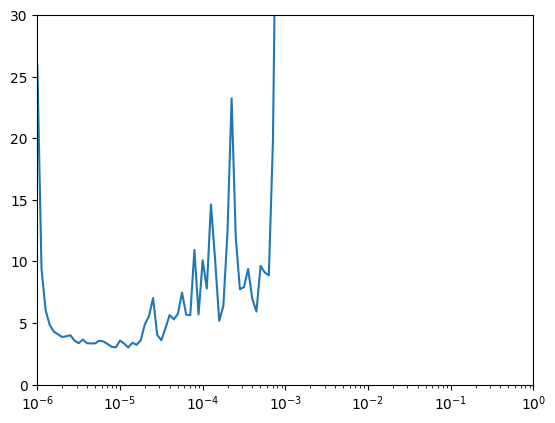

In [28]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [31]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

In [32]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.6646 - mae: 22.1583
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.8819 - mae: 11.3707
Epoch 3/50


2024-04-23 23:14:10.948218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-23 23:14:11.102586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9631 - mae: 8.4497 
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1727 - mae: 6.6542
Epoch 5/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 4.7292 - mae: 5.2067

2024-04-23 23:14:11.237838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:11.365860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4569 - mae: 5.9341
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6800 - mae: 5.1566
Epoch 7/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 4.0344 - mae: 4.5188

2024-04-23 23:14:11.508917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:11.650822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1519 - mae: 5.6222
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2094 - mae: 4.6848
Epoch 9/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.7524 - mae: 3.2027

2024-04-23 23:14:11.783079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:11.912622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2173 - mae: 4.6834
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2950 - mae: 4.7556
Epoch 11/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.8724 - mae: 4.3374

2024-04-23 23:14:12.042409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:12.169365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7157 - mae: 4.1818
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9181 - mae: 4.3824
Epoch 13/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.0693 - mae: 2.5035

2024-04-23 23:14:12.302613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:12.433110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9840 - mae: 4.4496
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8504 - mae: 4.3116
Epoch 15/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 4.9431 - mae: 5.4258

2024-04-23 23:14:12.558858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:12.695145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7825 - mae: 4.2390
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9767 - mae: 4.4397
Epoch 17/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.5962 - mae: 4.0812

2024-04-23 23:14:12.827231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:12.950739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6962 - mae: 4.1574
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6726 - mae: 4.1321
Epoch 19/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.2906 - mae: 2.7442

2024-04-23 23:14:13.073932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:13.196974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6108 - mae: 4.0788
Epoch 20/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0966 - mae: 3.5554
Epoch 21/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.5759 - mae: 5.0341

2024-04-23 23:14:13.323423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:13.453366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6447 - mae: 4.1030
Epoch 22/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4201 - mae: 3.8846
Epoch 23/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.2929 - mae: 2.7704

2024-04-23 23:14:13.578835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:13.705414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3499 - mae: 3.8121
Epoch 24/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3279 - mae: 3.7903
Epoch 25/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 2.0588 - mae: 2.5009

2024-04-23 23:14:13.831508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:13.963928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4355 - mae: 3.8931
Epoch 26/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8762 - mae: 4.3397
Epoch 27/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.4759 - mae: 2.9393

2024-04-23 23:14:14.101358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:14.225392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6775 - mae: 4.1361
Epoch 28/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2035 - mae: 3.6579
Epoch 29/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 3.4219 - mae: 3.8983

2024-04-23 23:14:14.349248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:14.475397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3657 - mae: 3.8255
Epoch 30/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1081 - mae: 3.5660
Epoch 31/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 10.0368 - mae: 10.4897

2024-04-23 23:14:14.600377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:14.725146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2076 - mae: 4.6703  
Epoch 32/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4123 - mae: 3.8752
Epoch 33/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.2443 - mae: 3.7082

2024-04-23 23:14:14.854387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:14.976135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4881 - mae: 3.9445
Epoch 34/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9526 - mae: 4.4111
Epoch 35/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 6.9026 - mae: 7.3722

2024-04-23 23:14:15.101534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:15.222982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9687 - mae: 4.4261
Epoch 36/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8276 - mae: 4.2876
Epoch 37/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.5858 - mae: 3.0586

2024-04-23 23:14:15.352556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:15.483085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0868 - mae: 3.5543
Epoch 38/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0662 - mae: 3.5227
Epoch 39/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 7.4132 - mae: 7.8421

2024-04-23 23:14:15.608435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:15.738069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9116 - mae: 4.3668
Epoch 40/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3717 - mae: 3.8363
Epoch 41/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.7296 - mae: 3.2093

2024-04-23 23:14:15.866838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:15.993976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3207 - mae: 3.7854
Epoch 42/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1828 - mae: 3.6350
Epoch 43/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.8182 - mae: 7.2633

2024-04-23 23:14:16.118885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:16.239117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3127 - mae: 3.7760
Epoch 44/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1370 - mae: 3.5946
Epoch 45/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.9353 - mae: 4.4278

2024-04-23 23:14:16.360243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:16.482053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0758 - mae: 3.5409
Epoch 46/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3855 - mae: 3.8408
Epoch 47/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.0769 - mae: 4.5375

2024-04-23 23:14:16.604996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:16.734385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5383 - mae: 4.0025
Epoch 48/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5411 - mae: 3.9972
Epoch 49/50
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.6243 - mae: 6.0943

2024-04-23 23:14:16.856232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:16.991248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4969 - mae: 3.9617
Epoch 50/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5765 - mae: 4.0393


2024-04-23 23:14:17.118374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-23 23:14:17.281257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [33]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

## Faster model forecasts

In the previous week you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:

- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [34]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


2024-04-23 23:14:17.540819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


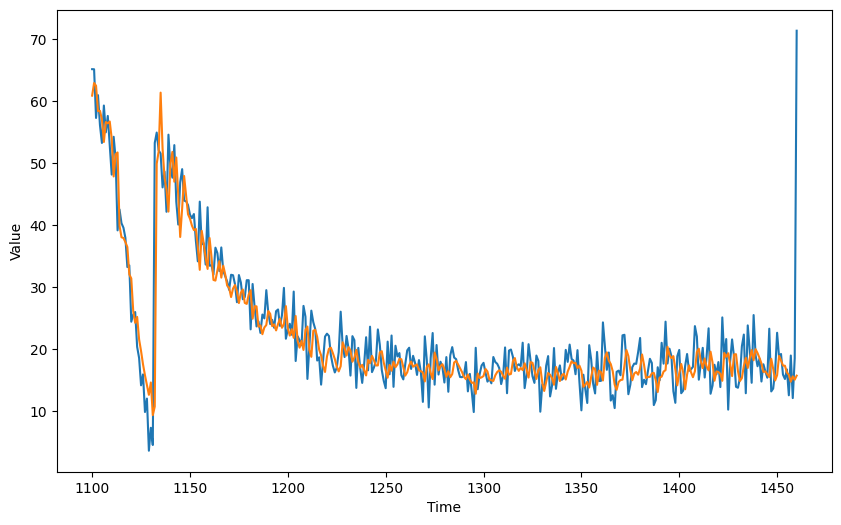

In [35]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/expected.png" width="500"/>
</div>

In [36]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 28.47, mae: 3.29 for forecast


**To pass this assignment your forecast should achieve an MAE of 4.5 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a `tar` file which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy `SavedModel` directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**


- Unlike last week, this time the model is saved using the `SavedModel` format. This is done because the HDF5 format does not fully support `Lambda` layers.

In [37]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model/my_model.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging Tensorflow's layers for sequence modelling such as `RNNs` and `LSTMs`! **This resulted in a forecast that matches (or even surpasses) the one from last week while training for half of the epochs.**

**Keep it up!**